<a href="https://colab.research.google.com/github/zierenberg/lecture_ModellingDiseaseSpread/blob/main/lecture_MDS_SIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm


import os
try:
  os.mkdir("figures")
except OSError:
  pass

#plt.rcParams.update({'figure.dpi': 200})
#plt.rcParams.update({'font.size': 22})


# Deterministic SIS Model


In [2]:
def SIS_derivative(u, t, rate_infection, rate_recovery):
    S, I = u
    N = S + I
    dSdt = -rate_infection * S * I / N + rate_recovery * I
    dIdt =  rate_infection * S * I / N - rate_recovery * I
    return dSdt, dIdt

def SIS_deterministic(rate_infection, rate_recovery, S0, I0, times):
  u0 = S0, I0
  
  # Integrate SIR equations over the time grid, t.
  sol = odeint(SIS_derivative, u0, times, args=(rate_infection, rate_recovery))
  S, I = sol.T
  return np.array(S), np.array(I)


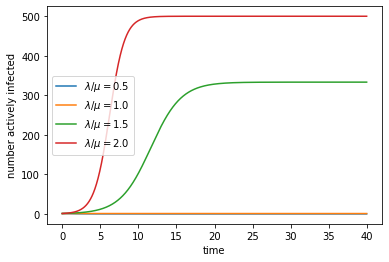

In [3]:
mu=1
I0=1
N=1000
S0=N-I0
times=np.arange(0,40,0.01)
for reproduction_number in [0.5, 1.0, 1.5, 2.0]:
  S, I = SIS_deterministic(reproduction_number*mu, mu, S0, I0, times)
  plt.plot(times, I, label='$\lambda/\mu=%.1f$'%reproduction_number)

plt.ylabel('number actively infected')
plt.xlabel('time')
#plt.yscale('log')
plt.legend()
plt.savefig('figures/deterministic_SIS_full_lambda.png', dpi=200)


# Stochastic SIS Model

In [4]:
def simulate(rate_infection, rate_recovery, S0, I0, times):
  S = S0; I = I0; 
  time = 0;

  # measurement variables
  trajectory_S = np.zeros(len(times))
  trajectory_I = np.zeros(len(times))
  i_meas = 0
  if times[i_meas] < 0:
    print("error")
    return -1
  if times[i_meas]==0:
    trajectory_S[0] = S0
    trajectory_I[0] = I0
    i_meas = 1

  # kinetic Monte Carlo simulation loop
  while I > 0 and time < times[-1]:
    dt, event = new_event(rate_infection, rate_recovery, S, I)
    time += dt

    # measure before update of system, because time will always surpass the 
    # measurement time
    while time > times[i_meas]:
      trajectory_S[i_meas] = S
      trajectory_I[i_meas] = I
      i_meas += 1
      if i_meas > len(times)-1:
        break
    
    # update system
    if event == "recovery":
      I -= 1
      S += 1
    if event == "infection":
      S -= 1
      I += 1

  return trajectory_S, trajectory_I
 
def new_event(rate_infection, rate_recovery, S, I):
  N = S + I 

  # calculate rates
  total_rate_infection = rate_infection * I * S / N
  total_rate_recovery  = rate_recovery  * I
  total_rate = total_rate_infection + total_rate_recovery

  # draw random exponentially distributed inter event time
  dt = np.random.exponential(1/total_rate)

  # select event with weight determinde by rate 
  event = ""
  if np.random.rand() < total_rate_infection/total_rate:
    event = "infection"
  else:
    event = "recovery"

  return dt, event   

Example

100%|██████████| 10000/10000 [02:46<00:00, 60.08it/s]


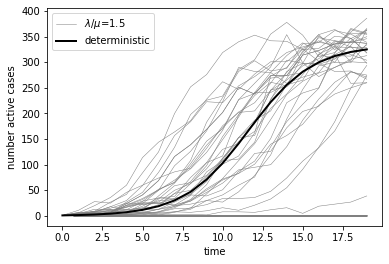

In [5]:
rate_recovery  = 1
rate_infection = 1.5
I0 = 1
N = int(1e3)
S0 = N-I0
time_total = 20

np.random.seed(1000)

num_trajectories = 10000
times = np.arange(0, time_total, 1)
list_Is_10 = [np.zeros(num_trajectories) for t in range(len(times))]
for i in tqdm(range(num_trajectories)):
  S, I = simulate(rate_infection, rate_recovery, S0, I0, times)
  for t in range(len(times)):
    list_Is_10[t][i] = I[t]

  if i==0:
    plt.plot(times, I, color='gray', linewidth=0.5, label='$\lambda/\mu$=%.1f'%(rate_infection/rate_recovery))
  if i < 100:
    plt.plot(times, I, color='gray', linewidth=0.5)

# deterministic solution
S_det, I_det = SIS_deterministic(rate_infection, rate_recovery, S0, I0, times)
plt.plot(times, I_det, color='black', label='deterministic', linewidth=2)

plt.xlabel('time')
plt.ylabel('number active cases')
plt.legend()
plt.savefig('figures/kineticMC_example_SIS_I0_1.png', dpi=200)

In [6]:
print(np.sum(list_Is_10[-1]==0)/num_trajectories)

0.6751


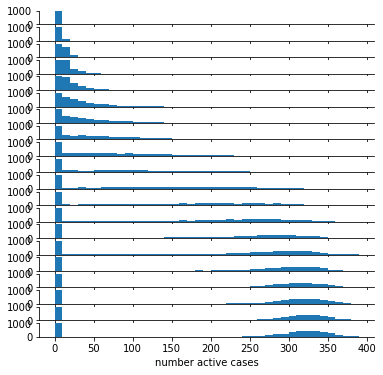

In [7]:
fig, axs = plt.subplots(len(times), 1, 
                        sharex=True, 
                        figsize=(6,6))

axs[-1].set_xlabel('number active cases')

for (i,t) in enumerate(range(len(times))):
  axs[i].hist(list_Is_10[t], bins=np.arange(0,400,10));
  axs[i].set_ylim(0,1000)
  axs[i].spines["top"].set_visible(False)
  axs[i].spines["right"].set_visible(False)

plt.savefig('figures/kineticMC_example_SIS_I0_1_distributions.png', dpi=200)

# Export

In [8]:
! zip figures.zip figures/* 

  adding: figures/deterministic_SIS_full_lambda.png (deflated 10%)
  adding: figures/kineticMC_example_SIS_I0_1_distributions.png (deflated 29%)
  adding: figures/kineticMC_example_SIS_I0_1.png (deflated 12%)
